In [1]:
import gym.envs.toy_text.frozen_lake as frozen_lake # I guess `toy_text` is a separate package?
from gym import make
import gym
from gym.envs.registration import register, registry
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import myenv
from pprint import pprint
import warnings
import xlrd
import time
from matplotlib import colors

In [2]:
# These are the non-random maps
MAPS = {
    "4x4": [
        "SFFF",
        "FHFH",
        "FFFH",
        "HFFG"
    ],
    "8x8": [
        "SFFFFFFF",
        "FFFFFFFF",
        "FFFHFFFF",
        "FFFFFHFF",
        "FFFHFFFF",
        "FHHFFFHF",
        "FHFFHFHF",
        "FFFHFFFG"
    ],
    "16x16" : [
        'SFFFFFHHFFFFFFFF',
        'FFFFHFFHFFFFFFHF',
        'FHFFFFFHFHFHFFFF',
        'HFFHFFFFFFFFFHFH',
        'FHFFFFHHFFFHHFHF',
        'FHFFHFHFFFFHFFFF',
        'FFHFFFFHFFFHHHHF',
        'HFHFFFFFFFFFFFFH',
        'FFFFFFFFFHFFFFHF',
        'FFFFFFHHFHFFFFFH',
        'FFHFFFFFFHFFFHFF',
        'FFFHHFHFFFFFHFFF',
        'FFFFFHFHFFFFHFFF',
        'HHHHHFFFHFFHFFFF',
        'FHFFHFFFFFFFFFFF',
        'FFHFHHFFHFFFFFFG'
    ]
}

In [3]:
def sixteen_by_sixteen_map():
    return frozen_lake.generate_random_map(size=16)

In [4]:
# ##
# Utility Functions
# ##

def getStateReward(env):
    n_states = env.observation_space.n
    Rs = np.empty(n_states)
    Rs.fill(np.nan)
    p = env.P
    for state in p:
        for action_commanded in p[state]:
            for action_possible in p[state][action_commanded]:
                Rs[action_possible[1]] = action_possible[2]
    
    return Rs 

In [5]:
def print_value(V, width=4, height=4):
    return np.around(np.resize(V, (width, height)), 4)

# https://gist.github.com/braingineer/d801735dac07ff3ac4d746e1f218ab75
# matprint.py Pretty print a matrix in Python 3 with numpy
def matprint(mat, fmt="g"):
    if mat[0][0] in ["←", "↓", "→", "↑"]:
        fmt = 's'# fmt='s' for arrows
    if mat[0][0] in [b'S', b'F', b'H', b'G']:
        fmt = 's'
        mat = mat.astype('<U8')
    col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
    for x in mat:
        for i, y in enumerate(x):
            print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
        print("")

In [6]:
# let's plot the policy matrix (as in Part 1). according to
# https://github.com/openai/gym/blob/master/gym/envs/toy_text/frozen_lake.py
# LEFT = 0   DOWN = 1   RIGHT = 2  UP = 3
def print_policy(V, width=4, height=4):
    table = {0: "←", 1: "↓", 2: "→", 3: "↑"}
    policy = np.resize(V, (width, height))
    
    # transform using the dictionary
    return np.vectorize(table.get)(policy)

In [7]:
def epsilon_greedy(Q, s, qepsilon, rand_action):
    rand = np.random.uniform()
    if rand < qepsilon:
        # the sample() method from the environment allows
        # to randomly sample an action from the set of actions
        return rand_action
    else:
        # act greedily by selecting the best action possible in the current state
        return np.argmax(Q[s, :])

In [8]:
def Qlearning(env, qepsilon=0.1, lr=0.8, qgamma=0.9, episodes=10000, initial=0, decay=False, report=False):
    # initialize our Q-table: matrix of size [n_states, n_actions] with zeros
    n_states, n_actions = env.observation_space.n, env.action_space.n
    Q = np.ones((n_states, n_actions))*initial
    #Q_old = Q.copy()*0

    # get a single list of state descriptions: 'S', 'H', 'F', 'G'
    desc_states = [ s.astype('<U8')[0] for row in env.desc for s in row ] 
    rewards_per_episode = list()
    times_per_episode = list()
    for episode in range(episodes):
        if(episode%500==0):
            print('episode = ', episode)
        
        state = env.reset()
        terminate = False # did the game end ?

        if decay:
            decay_e = 1
            
        total_episode_reward = 0
        start=time.time()
        while True:
            # choose an action using the epsilon greedy strategy
            if decay:
                qepsilon = 1.0/decay_e
                decay_e += 1
            action = epsilon_greedy(Q, state, qepsilon, env.action_space.sample())

            # execute the action. The environment provides us
            # 4 values: 
            # - the next_state we ended in after executing our action
            # - the reward we get from executing that action
            # - whether or not the game ended
            # - the probability of executing our action 
            # (we don't use this information here)
            next_state, reward, terminate, _ = env.step(action)

            if desc_states[next_state] == 'H': # if the agent falls in an hole
                r = reward -1 # then apply the state reward
                # the Q-value of the terminal state equals the reward
                Q[next_state] = np.ones(n_actions) * r
                
            elif desc_states[next_state] in ['S', 'F']: # the agent is in a frozen tile
                r = reward # give the agent the state reward

            elif desc_states[next_state] == 'G': # the agent reach the goal state
                r = reward # give him a big reward
                # the Q-value of the terminal state equals the reward
                Q[next_state] = np.ones(n_actions) * r

            # Q-learning update
            Q[state,action] = Q[state,action] + lr * (r + qgamma * np.max(Q[next_state, :]) - Q[state, action])
            total_episode_reward = total_episode_reward + r
            # move the agent to the new state before executing the next iteration
            state = next_state

            # if we reach the goal state or fall in an hole
            # end the current episode
            if terminate:
                break    
        #print(Q_old, '\n', Q, '\n', np.allclose(Q_old, Q))
        end=time.time()    
        ti=end-start
        times_per_episode.append(ti)
        rewards_per_episode.append(total_episode_reward)
        #if np.allclose(Q_old, Q):
        #    if report:
        #        print("Q-Learning converged after ", episode+1, "epochs")
        #    break
        #Q_old = Q.copy()

    
    return Q, episode+1, times_per_episode, rewards_per_episode

In [9]:
def Q_to_policy(Q):
    return np.argmax(Q, axis=1)

def Qlearning_trajectory(env, Q, max_steps=100, render=True, report=True):
    state = env.reset() # reinitialize the environment
    i = 0
    while i < max_steps:
        # once the agent has been trained, it
        # will take the best action in each state
        action = np.argmax(Q[state,:])

        # execute the action and recover a tuple of values
        next_state, _, terminate, _ = env.step(action)
        if render:
            print("####################")
            env.render() # display the new state of the game

        # move the agent to the new state before executing the next iteration
        state = next_state

        i += 1
        
        # if the agent falls in an hole or ends in the goal state
        if terminate:
            break # break out of the loop
    
    if report:
        print('\n--Final position--')
        env.render()
        print(f"Agent ended up at state {state} after {i} steps")

    return state, i

In [10]:
# ##
# Generate a Customized Frozen Lake
# ##

def getEnv(env_id='default', rH=0, rG=1, rF=0, desc=None, map_name='4x4', is_slippery=True, render_initial=True):

    if env_id in gym.envs.registry.env_specs:
        del gym.envs.registry.env_specs[env_id]

    register(
        id=env_id, # name given to this new environment
        entry_point='myenv:CustomizedFrozenLake', # env entry point
        kwargs={'rH': rH, 'rG': rG, 'rF': rF, 
                'desc': desc,
                'map_name': map_name, 
                'is_slippery': is_slippery} # argument passed to the env
    )

    this_env = make(env_id)

    if render_initial:
        print('--Board--')
        this_env.render()
        print('\n--Actions for Position to the Left of the Goal--')
        pprint(this_env.P[this_env.nS - 2])
    
    return this_env

In [11]:
#Default settings, uncomment to just use these
settings = {'rH': [-1],
 'rG': [1],
 'rF': [-0.2],
 'size': [16],
 'p': [0.8],
 'is_slippery': [False],
 'render_initial': [True],
 'epsilon': [1e-08],
 'gamma': [0.8],
 'max_iter': [10000],
 'qepsilon': [0.1],
 'lr': [0.8],
 'qgamma': [0.95],
 'episodes': [10000],
 'initial': [1],
 'decay': [True],
 'report': [True],
 'display_print': [True]}

In [12]:
# Determine the number of runs
n_settings = len(settings['rH'])
print(n_settings)

1


In [13]:
n=0
# Load settings
rH = settings['rH'][n] # -1 #-5 # reward for H(ole)
rG = settings['rG'][n] #1 # 10 # reward for G(oal)
rF = settings['rF'][n] #-0.2# reward includes S(tart) and F(rozen)
size = settings['size'][n] #4 # height and width of square gridworld, [4, 8, 16] are included in cs7641assn4.py 
p = settings['p'][n] #0.8 # if generating a random map probability that a grid will be F(rozen)
map_name = 'x'.join([str(size)]*2) # None, if you want a random map
print('map_name is ', map_name)
desc = MAPS[map_name] # None, if you want a random map
is_slippery = settings['is_slippery'][n] #False
render_initial = settings['render_initial'][n] # True

epsilon = settings['epsilon'][n] #1e-8 # convergence threshold for policy/value iteration
gamma = settings['gamma'][n] #0.8 # discount parameter for past policy/value iterations
max_iter = settings['max_iter'][n] #10000 # maximum iterations for slowly converging policy/value iteration 

# Qlearning(env, rH=0, rG=1, rF=0, qepsilon=0.1, lr=0.8, gamma=0.95, episodes=10000)
qepsilon = settings['qepsilon'][n] #0.1 # epsilon value for the Q-learning epsilon greedy strategy
lr = settings['lr'][n] #0.8 # Q-learning rate
qgamma = settings['qgamma'][n] #0.95 # Q-Learning discount factor
episodes = settings['episodes'][n] #10000 # number of Q-learning episodes
initial = settings['initial'][n] #0 # value to initialize the Q grid
decay = settings['decay'][n] #True

# Printing options
report = settings['report'][n] #True # For cs7641assn4.py policy and value iteration functions
display_print = settings['display_print'][n] #True # For this script

# Create Environment
env = getEnv(env_id='hw4-FrozenLake-v0', rH=rH, rG=rG, rF=rF, 
                desc=desc,  
                is_slippery=is_slippery, render_initial=True)

# Store a representation of the map
env_desc = env.desc.astype('<U8')

# Store a representation of the state rewards
env_rs = getStateReward(env)

if display_print:
    # Display reward at each state
    print('\n--Reward Values at Each State--')
    matprint(print_value(env_rs, width=size, height=size))

map_name is  16x16
--Board--

SFFFFFHHFFFFFFFF
FFFFHFFHFFFFFFHF
FHFFFFFHFHFHFFFF
HFFHFFFFFFFFFHFH
FHFFFFHHFFFHHFHF
FHFFHFHFFFFHFFFF
FFHFFFFHFFFHHHHF
HFHFFFFFFFFFFFFH
FFFFFFFFFHFFFFHF
FFFFFFHHFHFFFFFH
FFHFFFFFFHFFFHFF
FFFHHFHFFFFFHFFF
FFFFFHFHFFFFHFFF
HHHHHFFFHFFHFFFF
FHFFHFFFFFFFFFFF
FFHFHHFFHFFFFFFG

--Actions for Position to the Left of the Goal--
{0: [(1.0, 253, -0.2, False)],
 1: [(1.0, 254, -0.2, False)],
 2: [(1.0, 255, 1, True)],
 3: [(1.0, 238, -0.2, False)]}

--Reward Values at Each State--
-0.2  -0.2  -0.2  -0.2  -0.2  -0.2    -1    -1  -0.2  -0.2  -0.2  -0.2  -0.2  -0.2  -0.2  -0.2  
-0.2  -0.2  -0.2  -0.2    -1  -0.2  -0.2    -1  -0.2  -0.2  -0.2  -0.2  -0.2  -0.2    -1  -0.2  
-0.2    -1  -0.2  -0.2  -0.2  -0.2  -0.2    -1  -0.2    -1  -0.2    -1  -0.2  -0.2  -0.2  -0.2  
  -1  -0.2  -0.2    -1  -0.2  -0.2  -0.2  -0.2  -0.2  -0.2  -0.2  -0.2  -0.2    -1  -0.2    -1  
-0.2    -1  -0.2  -0.2  -0.2  -0.2    -1    -1  -0.2  -0.2  -0.2    -1    -1  -0.2    -1  -0.2  
-0.2    -1

In [14]:
#Q_table, neps = Qlearning(env, qepsilon=1e-3, lr=0.001, qgamma=qgamma, 
#                            episodes=episodes, initial=initial, 
#                            decay=decay, report=True)
#Q_table, neps = Qlearning(env, qepsilon=0.1, lr=0.8, qgamma=0.9, episodes=10000)

In [15]:
Q_table, neps, times_per_episode, rewards_per_episode = Qlearning(env, qepsilon=0.1, 
                                                                  lr=0.8, qgamma=0.9, 
                                                                  episodes=10000)

episode =  0
episode =  500
episode =  1000
episode =  1500
episode =  2000
episode =  2500
episode =  3000
episode =  3500
episode =  4000
episode =  4500
episode =  5000
episode =  5500
episode =  6000
episode =  6500
episode =  7000
episode =  7500
episode =  8000
episode =  8500
episode =  9000
episode =  9500


In [16]:
Q_table

array([[-1.83467448, -1.81630498, -1.81630498, -1.83467448],
       [-1.83467448, -1.79589442, -1.79589442, -1.81630498],
       [-1.81630498, -1.77321603, -1.77321603, -1.79589442],
       ...,
       [ 0.8431    ,  1.159     ,  1.51      ,  0.8431    ],
       [ 1.159     ,  1.51      ,  1.9       ,  1.159     ],
       [ 1.        ,  1.        ,  1.        ,  1.        ]])

In [17]:
act0 = Q_to_policy(Q_table)


In [18]:
def act_names(x):
    dt = {0:'left', 1:'down', 2:'right', 3:'up'}
    return dt[x]
act_np = np.vectorize(act_names)
#act = np.argmax(Q_table, axis=1)
act = act_np(act0)
act = act.reshape(16,16)
print("Policy:\n", act)

Policy:
 [['down' 'down' 'down' 'right' 'right' 'down' 'left' 'left' 'right' 'up'
  'down' 'down' 'left' 'right' 'right' 'left']
 ['right' 'right' 'down' 'down' 'left' 'down' 'down' 'left' 'up' 'up'
  'down' 'right' 'down' 'left' 'left' 'right']
 ['up' 'left' 'down' 'right' 'down' 'down' 'down' 'left' 'down' 'left'
  'up' 'left' 'up' 'right' 'right' 'up']
 ['left' 'right' 'down' 'left' 'right' 'down' 'right' 'right' 'down'
  'down' 'down' 'right' 'up' 'left' 'up' 'left']
 ['left' 'left' 'down' 'down' 'right' 'down' 'left' 'left' 'down' 'down'
  'down' 'left' 'left' 'left' 'left' 'left']
 ['left' 'left' 'right' 'down' 'left' 'down' 'left' 'right' 'down'
  'right' 'down' 'left' 'left' 'left' 'left' 'left']
 ['right' 'left' 'left' 'down' 'down' 'down' 'down' 'left' 'down' 'down'
  'down' 'left' 'left' 'left' 'left' 'left']
 ['left' 'down' 'left' 'down' 'down' 'right' 'down' 'down' 'right'
  'right' 'down' 'down' 'down' 'down' 'left' 'left']
 ['right' 'up' 'right' 'right' 'right' 'right' '

In [19]:
data=np.ones([16,16])*20
data[15,2]=7
data[15,4]=7
data[15,5]=7
data[15,8]=7
data[14,1]=7
data[14,4]=7
data[13,0]=7
data[13,1]=7
data[13,2]=7
data[13,3]=7
data[13,4]=7
data[13,8]=7
data[13,11]=7
data[12,5]=7
data[12,7]=7
data[12,12]=7
data[11,3]=7
data[11,4]=7
data[11,6]=7
data[11,12]=7
data[10,2]=7
data[10,9]=7
data[10,14]=7
data[9,6]=7
data[9,7]=7
data[9,9]=7
data[9,15]=7
data[8,9]=7
data[8,14]=7
data[7,0]=7
data[7,1]=7
data[7,15]=7
data[6,2]=7
data[6,7]=7
data[6,11]=7
data[6,12]=7
data[6,13]=7
data[6,14]=7
data[5,1]=7
data[5,4]=7
data[5,6]=7
data[5,11]=7
data[0,0]=10
data[0,6]=7
data[0,7]=7
data[1,4]=7
data[1,7]=7
data[2,1]=7
data[2,7]=7
data[2,9]=7
data[2,11]=7
data[3,0]=7
data[3,3]=7
data[3,13]=7
data[3,15]=7
data[4,1]=7
data[4,6]=7
data[4,7]=7
data[4,11]=7
data[4,12]=7
data[4,14]=7
data[15,15]=0

In [20]:

# create discrete colormap
cmap = colors.ListedColormap(['green', 'red','orange','blue'])
bounds = [0,5,10,15,20]
norm = colors.BoundaryNorm(bounds, cmap.N)

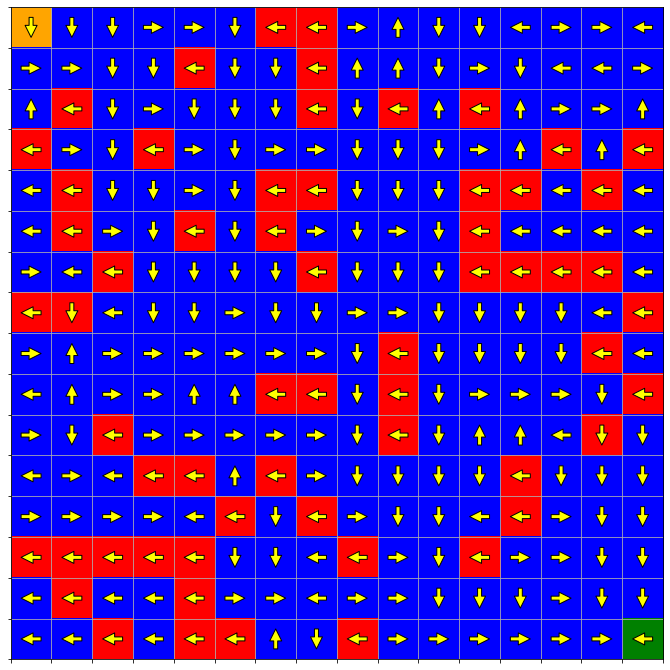

In [21]:
fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(data, cmap=cmap)

# draw gridlines
ax.set_xticks(np.arange(-.5, 16.5, 1));
ax.set_yticks(np.arange(-.5, 16.5, 1));
ax.grid(True)
ax.set_xticklabels([])
ax.set_yticklabels([])

for iy in range(16):
    for ix in range(16):
    #print(x)
        #if iy==1 and ix==1:
        #    continue
        #if iy==1 and ix==3:
        #    continue
        #if iy==3 and ix==0:
        #    continue
        #if iy==3 and ix==3:
        #    continue
        if act[iy,ix]=='down':
            #ax.text(x[1], x[0], policy[x], fontsize=25,      color='blue')
            ax.annotate('', xy=(ix, iy+0.25), xytext=(ix, iy-0.25),
                arrowprops=dict(facecolor='yellow', shrink=0.01))
        elif act[iy,ix]=='left':
            #ax.text(x[1], x[0], policy[x], fontsize=25,      color='green')
            ax.annotate('', xy=(ix-0.25, iy), xytext=(ix+0.25, iy),
                arrowprops=dict(facecolor='yellow', shrink=0.01))
        elif act[iy,ix]=='up':  
            #ax.text(x[1], x[0], policy[x], fontsize=25,      color='blueviolet')
            ax.annotate('', xy=(ix, iy-0.25), xytext=(ix, iy+0.25),
                arrowprops=dict(facecolor='yellow', shrink=0.01))
        else:
            ax.annotate('', xy=(ix+0.25, iy), xytext=(ix-0.25, iy),
                arrowprops=dict(facecolor='yellow', shrink=0.01))

In [22]:
print("Mean reward per thousand episodes")
mean_episode_rewards=[]
mean_episode_times=[]
episodes=np.arange(100,10000+100,100).astype('int')
for i in range(100):
    mean_reward=np.mean(rewards_per_episode[100*i:100*(i+1)])
    print((i+1)*100,": mean espiode reward: ",mean_reward)
    mean_episode_rewards.append(mean_reward)
    mean_time=np.mean(times_per_episode[100*i:100*(i+1)])
    mean_episode_times.append(mean_time)
print("\n\n")

Mean reward per thousand episodes
100 : mean espiode reward:  -5.838000000000002
200 : mean espiode reward:  -7.522000000000002
300 : mean espiode reward:  -9.845999999999997
400 : mean espiode reward:  -8.198
500 : mean espiode reward:  -5.324000000000002
600 : mean espiode reward:  -5.210000000000003
700 : mean espiode reward:  -5.218000000000003
800 : mean espiode reward:  -5.0340000000000025
900 : mean espiode reward:  -5.306000000000003
1000 : mean espiode reward:  -5.200000000000002
1100 : mean espiode reward:  -5.288000000000003
1200 : mean espiode reward:  -5.216000000000001
1300 : mean espiode reward:  -5.162000000000002
1400 : mean espiode reward:  -5.206000000000001
1500 : mean espiode reward:  -5.232000000000003
1600 : mean espiode reward:  -5.270000000000002
1700 : mean espiode reward:  -5.4380000000000015
1800 : mean espiode reward:  -4.916000000000002
1900 : mean espiode reward:  -5.130000000000003
2000 : mean espiode reward:  -5.168000000000002
2100 : mean espiode rewar

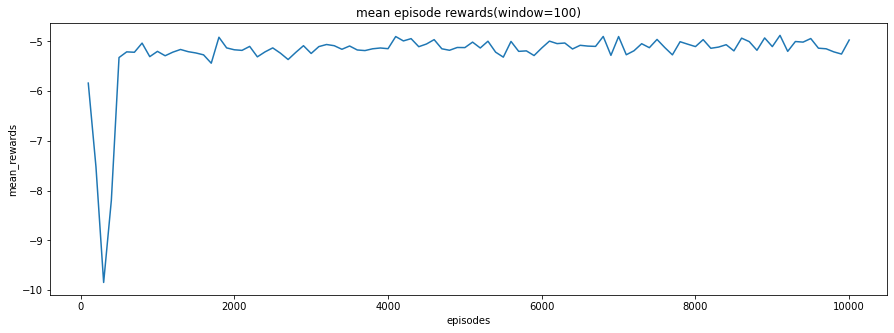

In [23]:
fig=plt.figure(figsize=[15,5])
plt.plot(episodes,mean_episode_rewards)
plt.title('mean episode rewards(window=100)')
plt.xlabel('episodes')
plt.ylabel('mean_rewards')
plt.show()

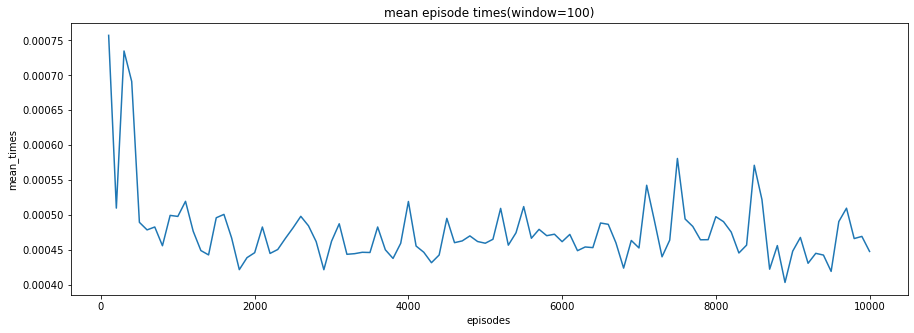

In [24]:
fig=plt.figure(figsize=[15,5])
plt.plot(episodes,mean_episode_times)
plt.title('mean episode times(window=100)')
plt.xlabel('episodes')
plt.ylabel('mean_times')
plt.show()

In [25]:
print('mean reward is ', np.mean(mean_episode_rewards))

mean reward is  -5.231940000000002


In [26]:
print('mean time is ', np.mean(mean_episode_times))

mean time is  0.000476798129081726
